# Maize Selection Trade-offs

Jupyter notebook describes ecohydrological model developed by Natasha Krell, Noah Spahn and Kelly Caylor to demonstrate crop water use of maize under various rainfall climatologies in central Kenya. The script below runs the model, simulates rainfall, outputs the results, and generates figures.

Last updated: 3 November 2019

## 1. Background
From Ridge to Reef notebook, Chapter 3.

### Tradeoffs between days to maturity and exposure to climate variability

This tradeoff is harder to quantify. Instead, we will model the interaction between days to maturity and crop failure. Our strategy will be to examine a very field-scale water balance that looks only at relative water availability \[mm/mm\], $s$, daily rainfall, $R$ \[mm/day\], and daily water demand, which we will characterize as reference evapotranspiration, $ET_0$ \[mm/day\]. Because temperature is relatively constant, we will assume that $ET_0$ is constant. Therefore our water balance is simply:


$$ \frac{dS}{dt} = R(t) - ET_0 $$

Note: need this equation to match what's in the model: dsdt(t) = R(t) - E(s,t) - L(s,t) - Q(s,t)

This formulation ignores many important processes related to soil water storage and plant response to drought. As defined, it is essentially a cumulative dryness index; during periods of the season when $\sum_t R(t) > t \times ET_0$, there will accumulation of water in the soil. During periods when $\sum_t R(t) < t \times ET_0$, the soil will dry out. 

Because the amount of plant available water in the soil in bounded between zero and some maximum, we add an additional parameter, $S_{max}$, which is the maximum amount of water `[mm]` that can be stored in the root zone. Now our model looks like this:

$$
\begin{eqnarray}
    \frac{dS}{dt} &=& R(t) - ET_0 & if & (0 \leq S \leq S_{max}) \\
    & & & else; \\
    \frac{dS}{dt} &=& 0 
\end{eqnarray}       
$$

Assuming a typical value of porosity is 0.4 and soil depth is 500 mm (0.5 meters), the value of $S_{max}$ is 200, here is what our model looks like in python:

```python
n = 0.4  # Porosity, [m3/m3]
Zr = 500 # Rooting depth [mm]
S_max = n*Zr    # Max soil water storage [mm]
S[0] = 30  # Initial soil water storage [mm]
ET_0 = 6.5 # Daily reference evapotranspiration [mm]

S = np.zeros(len(R)) # Pre-allocate the array for S
dSdt = np.zeros(len(R))# Pre-allocate the array for dSdt

for t in range(len(R)):
    dSdt[t] = R[t] - ET_0
    S[t+1] = S[t] + dSdt[t]
    if S[t+1] < S_max:
        S[t+1] = S_max
    if S[t+1] < 0:
        S[t+1] = 0
```

## 2. Import ecohydro model

Model is saved as `runmodel.py` in folder. Evaporation and transpiration are seperated to calculate ET. 

In [1]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd
#os.chdir('../maize-Toff')

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel

In [2]:
# initialize objects
climate = Climate() # uses default climate values
soil = Soil('loam')
crop = Crop(soil=soil) # previously kc_max=1.2, LAI_max=2.0, T_max=4.0
soil.set_nZr(crop)  
model = CropModel(crop=crop,soil=soil,climate=climate)

model.run()
model.output()

done


,kc,LAI,R,s,E,ET,T,L,dsdt
0,0.300000,0.750000,0.000000,0.300000,0.099097,0.099097,0.000000,0.000000,-0.099097
1,0.300000,0.750000,54.675044,0.299561,0.098010,0.098010,0.000000,0.000000,54.577034
2,0.300000,0.750000,0.000000,0.541587,1.116740,1.935788,0.819048,0.000000,-1.935788
3,0.300000,0.750000,3.561910,0.533003,1.069400,1.855218,0.785818,0.000000,1.706692
4,0.300000,0.750000,0.000000,0.540571,1.111102,1.926217,0.815115,0.000000,-1.926217
5,0.300000,0.750000,1.849686,0.532029,1.064075,1.846124,0.782049,0.000000,0.003561
6,0.300000,0.750000,0.000000,0.532045,1.064162,1.846272,0.782110,0.000000,-1.846272
7,0.300000,0.750000,0.000000,0.523858,1.019726,1.770143,0.750417,0.000000,-1.770143
8,0.300000,0.750000,0.000000,0.516008,0.977720,1.697751,0.720030,0.000000,-1.697751
9,0.300000,0.750000,0.000000,0.508479,0.937990,1.628876,0.690887,0.000000,-1.628876


### a. Inspecting the model

In [3]:
# this should be the first term of LAI
pow(3.0/1.2,1)*0.3

# this should be the first E term
6.5*exp(-6.5*0.75)

0.04962811242258975

### b. Model tests

Something is wrong with `s`, `theta`, or `psi`, which are all methods of Soil. To figure out which of these might be causing the issue, we can test various relative soil moisture values using this figure from Liao et al. 2001b showing the relationship between relative soil moisture (x-axis: low levels of soil moisture = 0 and max soil moisture = 1) and evapotranspiration (y-axis: the sum of losses from both plant transpiration and soil evaporation).

![Create figure 5 from Liao et al. 2001b](output/Liao2001bFig5.jpg)

 When soil moisture is between field capacity (s_fc) and 1, the soil moisture is sufficient and maximum ET, (E_max), is independent of soil moisture, (s). Between field capacity (s_fc) and S* (s_star), both plant transpiration and soil evaporation result in soil moisture losses. S* is the point at which soil water loss is due to both transpiration and evaporation before soil moisture levels decrease enough for transpiration to be reduced. When soil moisture is below S*, plants start reducing transpiration: they close their stomata to prevent water loss, and thus there is a linear decrease to wilting point (s_w) as photosynthesis-related transpiration and water uptake from roots slows until reaching wilting point. At wilting point there are very low levels of soil moisture, and there is only evaporation. Between wilting point and the hygroscopic point (s_h), soil water is depleteed only by evaporation.

We wrote tests (see test_sand.py) based on the following questions:

**1. Is the hygroscopic soil moisture (s_h) less than soil moisture at wilting point (s_w)?**

```python

print(soil.sh)
print(crop.sw)

if soil.sh <= crop.sw:
    print("True")
```

**2. Is the conversion from mm to MPa is correct for sw? TODO**
**3. Is the conversion for s_star correct? TODO**

```python

print(crop.sw)
print(crop.sw_MPa)

print(crop.s_star)
print(crop.s_star_MPa)

```

**4. Is field capacity less than 1?**

```python
if soil.sfc <= 1:
    print("True")

pow((soil.sfc - soil.sh)/(1-soil.sh),1)*100
```

**5. Do the hygroscopic values correspond with expected values from Liao et al. 2001b, Figure 6: ca. 0.07 for loamy sand, and 0.19 for loam?**

```python
# Loamy sand
# initialize objects
climate = Climate() # uses default climate values
soil = Soil('loamy sand')
crop = Crop(soil=soil) 
soil.set_nZr(crop)
model = CropModel(crop=crop,soil=soil,climate=climate)
print(soil.sh)

# Loam
climate = Climate() # uses default climate values
soil = Soil('loam')

crop = Crop(soil=soil) 
soil.set_nZr(crop)
model = CropModel(crop=crop,soil=soil,climate=climate)

print(soil.sh)

```

In [4]:
pow(0.05/(0.0417*60*24),1/(2*5.39+3))

0.5977531541625819

### c. Figures

In [5]:
!pwd

/Users/charrua/Box Sync/waves/maize-Toff


0     175.0
1     175.0
2     175.0
3     175.0
4     175.0
5     165.0
6     165.0
7     165.0
8     165.0
9     175.0
10    160.0
11    165.0
12    120.0
13    135.0
14    125.0
15    125.0
16    105.0
17     97.5
18    110.0
19    110.0
20    110.0
21    110.0
22     97.5
23     97.5
Name: days_to_maturity, dtype: float64
0     4680
1     4680
2     4500
3     4320
4     4320
5     4140
6     3960
7     3780
8     3600
9     3420
10    2880
11    2520
12    2520
13    2340
14    2160
15    2070
16    1800
17    1350
18    1350
19    1350
20    1350
21    1710
22    1350
23    1170
Name: yield_kg_ha, dtype: int64
0.8821342568671494
m 38.209721942492855
b -2572.222327532072


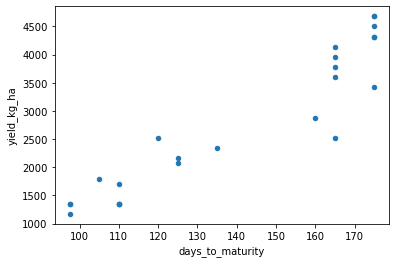

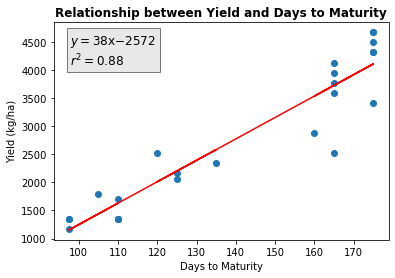

In [63]:
hybrid_data = pd.read_csv('data/hybrid_yields.csv')
hybrid_data

hybrid_data.plot.scatter(x='days_to_maturity', y='yield_kg_ha')

X = hybrid_data.days_to_maturity
y = hybrid_data.yield_kg_ha
#print(X)
#print(y)

# linear regression: https://medium.com/@mjfstanford/simple-linear-regression-in-python-905b759ef0e6
denominator = X.dot(X) - X.mean() * X.sum()
m = ( X.dot(y) - y.mean() * X.sum() ) / denominator
b = (y.mean() * X.dot(X) - X.mean() * X.dot(y) ) / denominator

y_pred = m*X + b

fig, ax = plt.subplots()

ax.scatter(X,y)
ax.plot(X,y_pred,'r')

# Calculate residuals
res = y - y_pred
tot = y - y.mean()

R_squared = 1 - res.dot(res) / tot.dot(tot)
print(R_squared)

print('m',m)
print('b',b)

textstr = '\n'.join((
    r'$ y = %1.0f$x' % (m, )+'$  %1.0f$' % (b, ),
    r'$r^2=%.2f$' % (R_squared, )))           
           
props = dict(boxstyle='square', facecolor='lightgray', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.xlabel('Days to Maturity')
plt.ylabel('Yield (kg/ha)')
plt.title('Relationship between Yield and Days to Maturity', fontweight="bold")
plt.savefig('output/YieldvsDTM.png', dpi=500)
            

Determine best-fit linear relationship between these data and the $r^2$ value.


Previously done with back of the envelope:
Yield increases by 3500 kg/ha over about 80 days, which is 44 kg/ha per day.
Assuming 100-day variety yields 1250 kg/ha, our estimate of the y-intercept is -3150 kg/ha

Our equation for yield is:

$$
\begin{eqnarray}
    \text{yield} = 44*\text{days_to_maturity} - 3150 
\end{eqnarray}       
$$

### d. Other space to mess around

In [ ]:
# Check that the value of E_w (evaporation at wilting point) is less than E_max (max evapotranspiration)

# where to get E_w?
#climate.calc_E(soil.sh)

soil.s

soil.s(0.3)

soil.s

# this is a method that returns the relative soil moisture value given the volumetric water content.
# the input is theta which is an interval between 0 and porosity = 0.395

soil.n

# let's try and get linspace 0 to soil.n

PRECISION = 2

theta_values = np.linspace(0.1, soil.n, num=100).round(3)
theta_values
#len(theta_values)

#TODO: how to fix this: if I start with zero it throws an error below?

vals = np.array([soil.s(theta_) for theta_ in theta_values])

d = np.arange(101)
plt.plot(vals, '-')
plt.title('Hmmm')
plt.xlabel('Hmm')
plt.show()

In [ ]:
soil = Soil('sand')
soil.set_nZr(crop)

print(crop.s_star)
print(soil.sfc)

soil = Soil('clay')
soil.set_nZr(crop)

print(crop.s_star)
print(soil.sfc)


soil = Soil('loam')
soil.set_nZr(crop)

print(crop.s_star)
print(soil.sfc)

In [ ]:
soil.calc_L(0.395)

self = soil
self.Psi_L_MPa
self.theta(-1.5)
#self.n
#self.sfc
#self.psi(0.44*0.37) * 1E6 / 1000 / 9.8
pow(0.05/60/24/self.Ks,1/(2*self.b+3))*self.n

In [ ]:
self = soil

In [ ]:
# run for three maize varieties (early, med, late harvesting) and multiple seasons.
kc_collection = {}

for season_length in range(90, 120, 180):
  climate = Climate(t_seas=season_length)
  soil = Soil('sand')
  crop = Crop(soil=soil)
  soil.set_nZr(crop)
  model  = CropModel(crop=crop,soil=soil,climate=climate)
  model.run()
  kc_key = str(season_length)+"kc"
  kc_collection[kc_key] = model.kc
    
# now want to repeat this process but for multiple rainfall climatologies, soil types, different output variables, etc. etc.

In [ ]:
kc_collection

In [ ]:
model.n_days

In [ ]:
climate = Climate()
soil

In [ ]:
climate.calc_E(0.3, 1, soil=soil, plant=crop)

from math import exp
climate.ET_max*exp(-0.5*crop.calc_LAI(1)/crop.LAI_max)

(0.3-soil.sh)/(1-soil.sh)
soil.theta(-1000)

crop.s_star

crop.s_star_MPa


In [ ]:
soil.Psi_S_MPa

In [ ]:
soil = Soil('loamy sand')
soil.theta(-10)/soil.n


In [ ]:
# make some figures
print(model.E)
model.ET
model.ET_max
model.s

len(model.ET_max)

In [ ]:
model.T_max

Rainfall simulation stuff moved to maizeToff-EcohydroModel.ipynb